In [1]:
import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.1'
spark_version = 'spark-3.1.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graph

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("NaiveBayes").getOrCreate()

In [3]:
import pandas as pd
url = 'https://raw.githubusercontent.com/lisb020/scifi_book_game/main/BookList.csv'
pd_df = pd.read_csv(url)

pd_df.head()

,Unnamed: 0,Book_Title,Rating_score,Rating_votes,Book_Description,subgenre
0,0,Obsidian,4.17,236780,Starting over sucks When we moved to West Virg...,sf_aliens
1,1,Onyx,4.27,153429,BEING CONNECTED TO DAEMON BLACK SUCKS… Thanks ...,sf_aliens
2,2,The 5th Wave,4.03,400600,After the 1st wave only darkness remains Aft...,sf_aliens
3,3,The Host,3.84,915026,Melanie Stryder refuses to fade away The eart...,sf_aliens
4,5,Origin,4.35,93979,Daemon will do anything to get Katy back After...,sf_aliens


In [4]:
pd_df.drop(columns="Unnamed: 0", inplace=True)
pd_df.head()

,Book_Title,Rating_score,Rating_votes,Book_Description,subgenre
0,Obsidian,4.17,236780,Starting over sucks When we moved to West Virg...,sf_aliens
1,Onyx,4.27,153429,BEING CONNECTED TO DAEMON BLACK SUCKS… Thanks ...,sf_aliens
2,The 5th Wave,4.03,400600,After the 1st wave only darkness remains Aft...,sf_aliens
3,The Host,3.84,915026,Melanie Stryder refuses to fade away The eart...,sf_aliens
4,Origin,4.35,93979,Daemon will do anything to get Katy back After...,sf_aliens


In [5]:
import math
def round_down(row):
    if (row['Rating_score']>= 4):
      return str(2)
    elif (row['Rating_score']>= 1.5):
      return str(1)
    else:
      return str(0)


pd_df['rating'] = pd_df.apply (lambda row: round_down(row), axis=1) 

In [6]:
def remove_nums(row):
  output = ''.join(c for c in str(row['Book_Description']) if not c.isdigit())
  return(output)

pd_df['Book_Description'] = pd_df.apply (lambda row: remove_nums(row), axis=1) 

In [7]:
def remove_multi_spaces(row):
  single_spaces = " ".join(str(row['Book_Description']).split())
  return(single_spaces)

pd_df['Book_Description'] = pd_df.apply (lambda row: remove_multi_spaces(row), axis=1)   

In [8]:
def remove_unicode(row):
  string_encode = str(row['Book_Description']).encode("ascii", "ignore")
  return(string_encode.decode())

pd_df['Book_Description'] = pd_df.apply (lambda row: remove_unicode(row), axis=1) 

In [9]:
pd_df['subgenre'].unique()

array(['sf_aliens', 'sf_alternate_history', 'sf_alternate_universe',
       'sf_apocalyptic', 'sf_cyberpunk', 'sf_dystopia', 'sf_hard',
       'sf_military', 'sf_robots', 'sf_space_opera', 'sf_steampunk',
       'sf_time_travel'], dtype=object)

In [10]:
from pyspark.sql.types import *
mySchema = StructType([ StructField("Book_Title", StringType(), True)\
                       ,StructField("Rating_score", FloatType(), True)\
                       ,StructField("Rating_votes", LongType(), True)\
                       ,StructField("Book_Description", StringType(), True)\
                       ,StructField("subgenre", StringType(), True)\
                       ,StructField("rating", StringType(), True)])

In [11]:
spark_df = spark.createDataFrame(pd_df, schema=mySchema)
spark_df.show(10)

+----------------+------------+------------+--------------------+---------+------+
|      Book_Title|Rating_score|Rating_votes|    Book_Description| subgenre|rating|
+----------------+------------+------------+--------------------+---------+------+
|        Obsidian|        4.17|      236780|Starting over suc...|sf_aliens|     2|
|            Onyx|        4.27|      153429|BEING CONNECTED T...|sf_aliens|     2|
|    The 5th Wave|        4.03|      400600|After the st wave...|sf_aliens|     2|
|        The Host|        3.84|      915026|Melanie Stryder r...|sf_aliens|     1|
|          Origin|        4.35|       93979|Daemon will do an...|sf_aliens|     2|
|      Opposition|        4.37|       67740|Katy knows the wo...|sf_aliens|     2|
|I Am Number Four|        3.94|      319092|Nine of us came h...|sf_aliens|     1|
|The Infinite Sea|        3.87|      123001|How do you rid th...|sf_aliens|     1|
|         Shadows|        4.12|       36224|The last thing Da...|sf_aliens|     2|
|   

In [12]:
from pyspark.sql.functions import length
# Create a length column to be used as a future feature 
data_df = spark_df.withColumn('length', length(spark_df['Book_Description']))
data_df.show()

+--------------------+------------+------------+--------------------+---------+------+------+
|          Book_Title|Rating_score|Rating_votes|    Book_Description| subgenre|rating|length|
+--------------------+------------+------------+--------------------+---------+------+------+
|            Obsidian|        4.17|      236780|Starting over suc...|sf_aliens|     2|   830|
|                Onyx|        4.27|      153429|BEING CONNECTED T...|sf_aliens|     2|   987|
|        The 5th Wave|        4.03|      400600|After the st wave...|sf_aliens|     2|   691|
|            The Host|        3.84|      915026|Melanie Stryder r...|sf_aliens|     1|   580|
|              Origin|        4.35|       93979|Daemon will do an...|sf_aliens|     2|   858|
|          Opposition|        4.37|       67740|Katy knows the wo...|sf_aliens|     2|   828|
|    I Am Number Four|        3.94|      319092|Nine of us came h...|sf_aliens|     1|   716|
|    The Infinite Sea|        3.87|      123001|How do you r

In [29]:
#from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
import nltk
nltk.download('stopwords')

stop_words = nltk.corpus.stopwords.words("english")

namesurl = 'https://raw.githubusercontent.com/lisb020/scifi_book_game/main/names_data.csv'
names_df = pd.read_csv(namesurl)

list_of_names = names_df['name'].to_list()
name_list = []
for name in list_of_names:
    name_list.append(name.lower())

stop_words.extend(name_list)
number_words =["one","two","three","four","five","six","seven","eight","nine","ten"]
stop_words.extend(number_words)
print(stop_words)
def filter_stop_words(row, stop_words):
  desc_list = [word for word in row['Book_Description'].lower().split() if word not in stop_words] 
  return ' '.join(desc_list) 


pd_df['Book_Description'] = pd_df.apply (lambda row: filter_stop_words(row,stop_words), axis=1) 

# desc = filter_stop_words(pd_df['Book_Description'].iloc[10].lower(),stop_words)
# print(desc)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'bo

In [30]:
pd_df.to_csv("cleanedDf.csv")

In [ ]:
# # Create all the features to the data set

# # select the feature to categorize
# rating_to_num = StringIndexer(inputCol='rating',outputCol='label')
# #sub_genre = StringIndexer(inputCol='subgenre',outputCol='label')

# #prepare the Book Description Data as a feature
# tokenizer = Tokenizer(inputCol="Book_Description", outputCol="token_text")
# stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens',stopWords=stop_words)
# hashingTF = HashingTF(inputCol="stop_tokens", outputCol='hash_token')
# idf = IDF(inputCol='hash_token', outputCol='idf_token')

In [ ]:
# #prepare the Book Title data as a feature
# titletokenizer = Tokenizer(inputCol="Book_Title", outputCol="token_title")
# titlestopremove = StopWordsRemover(inputCol='token_title',outputCol='stop_title_tokens')
# titlehashingTF = HashingTF(inputCol="stop_title_tokens", outputCol='hash_title_token')
# titleidf = IDF(inputCol='hash_title_token', outputCol='idf_title_token')

In [ ]:
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.linalg import Vector

# # Create feature vectors
# #clean_up = VectorAssembler(inputCols=['idf_token'], outputCol='features')
# #clean_up = VectorAssembler(inputCols=['idf_title_token'], outputCol='features')
# clean_up = VectorAssembler(inputCols=['idf_token'], outputCol='features')
# #clean_up = VectorAssembler(inputCols=['idf_token'], outputCol='features')

In [ ]:
# # Create a and run a data processing Pipeline
# from pyspark.ml import Pipeline
# #data_prep_pipeline = Pipeline(stages=[sub_genre, tokenizer, stopremove, hashingTF, idf, clean_up])
# #data_prep_pipeline = Pipeline(stages=[sub_genre, titletokenizer, titlestopremove, titlehashingTF, titleidf,clean_up])
# #data_prep_pipeline = Pipeline(stages=[sub_genre, tokenizer, stopremove, hashingTF, idf,titletokenizer, titlestopremove, titlehashingTF, titleidf,clean_up])

# data_prep_pipeline = Pipeline(stages=[rating_to_num, tokenizer, stopremove, hashingTF, idf, clean_up])
# #data_prep_pipeline = Pipeline(stages=[rating_to_num, titletokenizer, titlestopremove, titlehashingTF, titleidf, clean_up])
# #data_prep_pipeline = Pipeline(stages=[rating_to_num, tokenizer, stopremove, hashingTF, idf,titletokenizer, titlestopremove, titlehashingTF, titleidf,clean_up])

In [ ]:
# cleaner = data_prep_pipeline.fit(data_df)
# cleaned = cleaner.transform(data_df)

In [ ]:
# # Show label and resulting features
# #cleaned.select(['label', 'features']).show(50)
# cleaned.select(['stop_tokens']).show(10,truncate = False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|stop_tokens                                                                                                                                                                                                     

In [ ]:
# from pyspark.ml.classification import NaiveBayes
# # Break data down into a training set and a testing set
# training, testing = cleaned.randomSplit([0.7, 0.3])

# # Create a Naive Bayes model and fit training data
# nb = NaiveBayes()
# predictor = nb.fit(training)

In [ ]:
# # Tranform the model with the testing data
# test_results = predictor.transform(testing)
# test_results['rating','prediction'].show(20,truncate=False)

+------+----------+
|rating|prediction|
+------+----------+
|1     |0.0       |
|1     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|1     |0.0       |
|1     |0.0       |
|1     |0.0       |
|1     |0.0       |
|1     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|1     |0.0       |
|0     |0.0       |
|1     |0.0       |
+------+----------+
only showing top 20 rows



In [ ]:
# ## Use the Class Evaluator for a cleaner description
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# acc_eval = MulticlassClassificationEvaluator()
# acc = acc_eval.evaluate(test_results)
# #print("Accuracy of model at predicting subgenre based on description was: %f" % acc)
# #print("Accuracy of model at predicting subgenre based on title was: %f" % acc)
# print("Accuracy of model at predicting rating based on description was: %f" % acc)
# #print("Accuracy of model at predicting rating based on title was: %f" % acc)
# #print("Accuracy of model at predicting rating based on description AND title was: %f" % acc)

Accuracy of model at predicting rating based on description was: 0.654387


In [ ]:
# dict = {'Book_Title':[''],'Rating_score':[0.0],'Rating_votes':[0],'Book_Description':["dog"],'subgenre':[''],'rating':['']}
# input_df = pd.DataFrame(dict)

In [ ]:
# input_spark_df = spark.createDataFrame(input_df, schema=mySchema)

In [ ]:
# input_spark_df.show()

+----------+------------+------------+----------------+--------+------+
|Book_Title|Rating_score|Rating_votes|Book_Description|subgenre|rating|
+----------+------------+------------+----------------+--------+------+
|          |         0.0|           0|             dog|        |      |
+----------+------------+------------+----------------+--------+------+



In [ ]:
# cleaner = data_prep_pipeline.fit(input_spark_df)
# cleaned = cleaner.transform(input_spark_df)
# cleaned.show()

+----------+------------+------------+----------------+--------+------+-----+----------+-----------+--------------------+--------------------+--------------+
|Book_Title|Rating_score|Rating_votes|Book_Description|subgenre|rating|label|token_text|stop_tokens|          hash_token|           idf_token|      features|
+----------+------------+------------+----------------+--------+------+-----+----------+-----------+--------------------+--------------------+--------------+
|          |         0.0|           0|             dog|        |      |  0.0|     [dog]|      [dog]|(262144,[54556],[...|(262144,[54556],[...|(262144,[],[])|
+----------+------------+------------+----------------+--------+------+-----+----------+-----------+--------------------+--------------------+--------------+



In [ ]:
# test_results = predictor.transform(cleaned)

In [ ]:
# test_results['rating','prediction'].show(20,truncate=False)

+------+----------+
|rating|prediction|
+------+----------+
|      |0.0       |
+------+----------+



In [38]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.preprocessing.text import Tokenizer as kerasTokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np


MAX_NB_WORDS = 50000
# This is fixed.
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 250

tokenizer = kerasTokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(pd_df['Book_Description'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 49873 unique tokens.


In [39]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [41]:

X = tokenizer.texts_to_sequences(pd_df['Book_Description'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Shape of data tensor: (10240, 250)


In [42]:
#SUBGENRE

Y = pd.get_dummies(pd_df['subgenre']).values
print('Shape of label tensor:', Y.shape)
print(Y)

Shape of label tensor: (10240, 12)
[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(9216, 250) (9216, 12)
(1024, 250) (1024, 12)


In [44]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(12, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 12)                1212      
Total params: 5,081,612
Trainable params: 5,081,612
Non-trainable params: 0
_________________________________________________________________
None


In [62]:

epochs = 8
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001))])

Epoch 1/8


ValueError: ignored

In [46]:
accr = model.evaluate(X_test,Y_test)
print('Model Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

32/32 [==============================] - 2s 62ms/step - loss: 1.9208 - accuracy: 0.5059
Model Test set
  Loss: 1.921
  Accuracy: 0.506


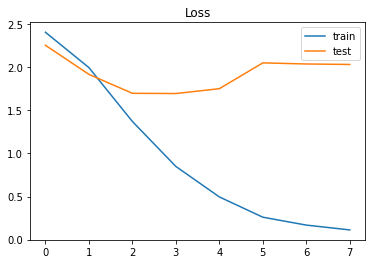

In [47]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

{'loss': [2.4074158668518066, 1.9968388080596924, 1.3716537952423096, 0.8490719795227051, 0.4951745271682739, 0.2597566246986389, 0.167925164103508, 0.11199414730072021], 'accuracy': [0.1466120034456253, 0.3289124667644501, 0.5221847295761108, 0.7065348625183105, 0.8489269614219666, 0.9266939759254456, 0.9527369141578674, 0.9709428548812866], 'val_loss': [2.256007671356201, 1.918239712715149, 1.6984721422195435, 1.6957206726074219, 1.751948595046997, 2.05161452293396, 2.038821220397949, 2.0333471298217773], 'val_accuracy': [0.22451193630695343, 0.3481561839580536, 0.4425162672996521, 0.47180044651031494, 0.4783080220222473, 0.47505423426628113, 0.45553144812583923, 0.4772234261035919]}


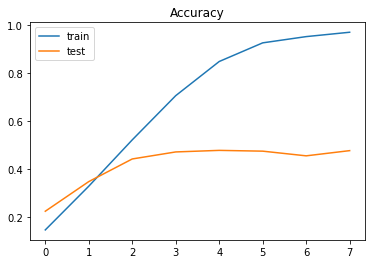

In [48]:
print(history.history)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [49]:
#Test with a single input

new_desc = ["The zombie apocalypse is over. The humans have won. Life is back to normal. And Rip is bored as hell. It's not much of a life sitting in a call center in the poor town of Spanish Shanty, Florida, answering emails like a drone and listening to customer complaints."]
seq = tokenizer.texts_to_sequences(new_desc)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = pd_df["subgenre"].unique()
print(pred, labels[np.argmax(pred)])

[[1.1643440e-03 2.0178068e-04 3.4993322e-04 9.9667645e-01 8.3987339e-04
  4.9874041e-04 7.7665918e-06 4.0701947e-05 1.0277240e-04 1.3980617e-06
  1.1092853e-04 5.3351469e-06]] sf_apocalyptic


In [ ]:
#RATING

Y = pd.get_dummies(pd_df['rating']).values
print('Shape of label tensor:', Y.shape)
print(Y)

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(9216, 250) (9216, 3)
(1024, 250) (1024, 3)


In [56]:
model2 = Sequential()
model2.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model2.add(SpatialDropout1D(0.2))
model2.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(3, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 303       
Total params: 5,080,703
Trainable params: 5,080,703
Non-trainable params: 0
_________________________________________________________________
None


In [63]:

epochs = 5
batch_size = 64

history = model2.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/5
130/130 [==============================] - 90s 690ms/step - loss: 0.0240 - accuracy: 0.9924 - val_loss: 1.6196 - val_accuracy: 0.6063
Epoch 2/5
130/130 [==============================] - 89s 685ms/step - loss: 0.0194 - accuracy: 0.9937 - val_loss: 1.8341 - val_accuracy: 0.6247
Epoch 3/5
130/130 [==============================] - 89s 685ms/step - loss: 0.0105 - accuracy: 0.9971 - val_loss: 1.9964 - val_accuracy: 0.6052
Epoch 4/5
130/130 [==============================] - 89s 686ms/step - loss: 0.0137 - accuracy: 0.9952 - val_loss: 1.8019 - val_accuracy: 0.5998
Epoch 5/5
130/130 [==============================] - 90s 688ms/step - loss: 0.0106 - accuracy: 0.9965 - val_loss: 2.1051 - val_accuracy: 0.6074


In [64]:
accr = model2.evaluate(X_test,Y_test)
print('Model2 Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

32/32 [==============================] - 2s 61ms/step - loss: 1.9651 - accuracy: 0.6094
Model2 Test set
  Loss: 1.965
  Accuracy: 0.609


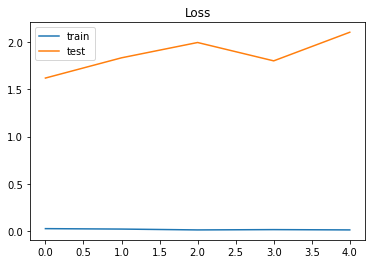

In [65]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

{'loss': [0.024043964222073555, 0.019434431567788124, 0.010518996976315975, 0.013674464076757431, 0.01062027644366026], 'accuracy': [0.9924041628837585, 0.9937304258346558, 0.9971063137054443, 0.9951772093772888, 0.996503472328186], 'val_loss': [1.619619607925415, 1.834128499031067, 1.9963676929473877, 1.801916480064392, 2.1050968170166016], 'val_accuracy': [0.6062906980514526, 0.6247288584709167, 0.6052060723304749, 0.5997830629348755, 0.6073752641677856]}


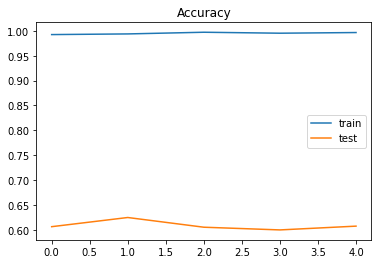

In [66]:
print(history.history)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [69]:
ratings = ['Great Read', 'Will get Read', 'take a chance']

In [67]:

tokenizer = kerasTokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(pd_df['Book_Description'].values)
word_index = tokenizer.word_index

In [74]:
# Run with a single input

new_desc = ["Deep in the Hungarian woods, the sacred magic of King Solomon lives on in his descendants. Gathering under the midnight stars, they perform small miracles and none are more gifted than the great Rabbi Isaac and his three daughters.Hannah, bookish and calm, can coax plants to grow even when the weather is bitterly cold. Sarah, defiant and strong, can control the impulsive nature of fire. And Levana, the fey one, can read the path of the stars to decipher their secrets."]
seq = tokenizer.texts_to_sequences(new_desc)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model2.predict(padded)
labels =ratings
print(pred, labels[np.argmax(pred)])

[[3.7090466e-04 8.3081285e-03 9.9132103e-01]] take a chance
